# <center> RBF-SVC on Amazon Fine Food Reviews Dataset</center>
___

###  <b>Exercise</b> :

1.	Download Amazon Fine Food Reviews dataset from Kaggle. You may have to create a Kaggle account to download data. (https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Split data into train and test using time based slicing as 70%  train & 30% test.
3.	Perform featurization, BoW, tf-idf,Avg Word2Vec, tf-idf-Word2Vec.
4.	Apply GridsearchCV and RandomsearchCV on train data to find optimal ‘c‘and optimal ‘gamma’.
5.	Apply RBF-SVC(Radial Basis Function – Support Vector Classification) on the dataset.
6.	To test the performance of the model, calculate test error, train error, accuracy,precision,recall,F1-score,confusion matrix(TPR,TNR,FPR,FNR)
7.  Write your observations in English as crisply and unambiguously as possible. Always quantify your results.


### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is a 2-class classification task, where we have to analyze, transform(BoW,TF-IDF,Avg Word2ec and TFIDF Word2Vec) and find a separating decision surface, which can evaluate whether a review is positive or negative.<span>

---


In [3]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import traceback
import sqlite3
import itertools
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import preprocessing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.externals import joblib

### (1) Load dataset :

Dataset Shape : 
 (100000, 11)

Column Names: 
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

Target Class label : 
positive    84741
negative    15259
Name: Score, dtype: int64



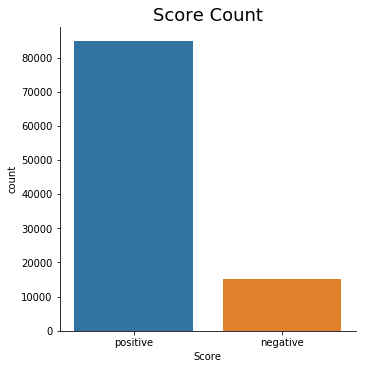

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
382,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
369,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19 05:30:00,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
188,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24 05:30:00,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
392,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,positive,2000-06-03 05:30:00,Research,I'm getting crazy.<p>Is it really impossible t...,get crazi realli imposs today find french vhs ...
350,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03 05:30:00,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...


In [10]:
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# For Data Cleaning Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=1JXCva5vXdIPgHbfNdD9sgnySqELoVtpy
# dataset - https://drive.google.com/open?id=1IoDoTT8TfDu53N6cyKg6xVCU-FDPHyIF

# For Text Preporcessing Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=18-AkTzzEhCwM_hflIbDNBMAP-imX4k4i
# dataset - https://drive.google.com/open?id=1SfDwwXFhDpjgtfIE5O_E80SO89xRc8Sa

# Load dataset
def load_review_dataset():
    # Create connection object to load sqlite dataset
    connection = sqlite3.connect('finalDataSet.sqlite')

    # Load data into pandas dataframe.
    reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

    # Drop index column 
    reviews_df = reviews_df.drop(columns=['index'])
    
    # Save data before sampling
    joblib.dump(reviews_df, 'reviews_364k.joblib') 
    
    # Take sample of reviews
    # 100K points taken, as RBF-SVC takes more time to train.
    reviews_df = reviews_df.sample(100000)
        
    # Convert timestamp to datetime.
    reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

    # Sort the data on the basis of time.
    reviews_df = reviews_df.sort_values(by=['Time'])

    print("Dataset Shape : \n",reviews_df.shape)
    print("\nColumn Names: \n",reviews_df.columns)
    print("\nTarget Class label : ")
    print(reviews_df['Score'].value_counts())
    print()   
    
    return reviews_df


# Load 'finalDataSet.sqlite' in panda's daraframe.
reviews_df = load_review_dataset()

# Split data into train and test
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(reviews_df['CleanedText'].values,
                                                    reviews_df['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False,
                                                    random_state=0)


# Plot score
sns.catplot(x ="Score",kind='count',data=reviews_df,height=5)
plt.title("Score Count", fontsize=18)
plt.show()
reviews_df.head()

In [11]:
###--- All utility variables and functions(After importing all the necessary packages, always run this cell first.) ---###

# hyperparameter C
list_c = []

# hyperparameter gamma
list_gamma = []

# Training Error
train_error = []

# Test Error
test_error = []


def plot_report_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):    
    plt.figure()
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    TN = confusion_matrix[0,0]       
    FP = confusion_matrix[0,1]  
    FN = confusion_matrix[1,0]
    TP = confusion_matrix[1,1]
    

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP)  
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Confusion Matrix Report"
    ptable.field_names = ['Term','Value']
    ptable.add_row(["TP (True Positive)",TP])
    ptable.add_row(["TN (True Negative)",TN])
    ptable.add_row(["FP (False Positive)",FP])
    ptable.add_row(["FN (False Negative)",FN])
    ptable.add_row(["TPR (True Positive Rate)= TP/(TP+FN))","{0:.2f}".format(TPR)])
    ptable.add_row(["TNR (True Negative Rate)= TN/(TN+FP))","{0:.2f}".format(TNR)])
    ptable.add_row(["FPR (False Positive Rate)= FP/(FP+TN))","{0:.2f}".format(FPR)])
    ptable.add_row(["FNR (False Negative Rate)= FN/(TP+FN))","{0:.2f}".format(FNR)])
    ptable.add_row(["ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN))","{0:.2f}%".format(ACC*100)])
    
    # Print pretty table values
    print(ptable)


def performance_measure(classifier,train_feature,test_feature):
    print("-------------------------- {0} --------------------------".format(type(classifier).__name__))           
            
    # Predict target class label
    predicted_y_test = classifier.predict(test_feature)
    
    # Predict train class label
    predicted_y_train = classifier.predict(train_feature)
            
    ptable = PrettyTable()
    if type(classifier) is GridSearchCV:
        ptable.title = "GridSearchCV"
    else:
        ptable.title = "RandomizedSearchCV"
                
    ptable.field_names = ["Hyperparameter (C)", "Hyperparameter (gamma)","Scoring","Mean","Variance"]

    list_means = classifier.cv_results_['mean_test_score']
    list_stds = classifier.cv_results_['std_test_score']
    list_params = classifier.cv_results_['params']   
       
    for mean, std, params in zip(list_means, list_stds, list_params):                
        ptable.add_row([params['C'],params['gamma'],"Accuracy", "{0:.2f}".format(mean), "{0:.2f}".format(std*2)])

               
    print()
    print(ptable)
    print()

    optimal_c = classifier.best_params_['C']
    optimal_gamma = classifier.best_params_['gamma']
    train_accuracy = accuracy_score(Y_TRAIN, predicted_y_train)
    test_accuracy = accuracy_score(Y_TEST, predicted_y_test)
    
    list_c.append(optimal_c)
    list_gamma.append(optimal_gamma)
    
    test_error.append(1 - test_accuracy)
    train_error.append(1 - train_accuracy)    
             
    # Print Optimal hyperparameter and corresponding accuracy
    ptable = PrettyTable()
    ptable.title = "Optimal hyperparameter & Testing accuracy score"
    ptable.field_names=["Cross Validation","Optimal Hyperparameter (C)","Optimal Hyperparameter (gamma)","Accuracy(%)"]
    ptable.add_row([type(classifier).__name__ ,optimal_c, optimal_gamma,"{0:.2f}".format(classifier.best_score_*100)])
    print(ptable)  
            
    # Print classification report
    print()          
    ptable = PrettyTable()
    ptable.title = "Classification Report with C = {0} and Gamma = {1}".format(optimal_c,optimal_gamma)
    ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
    report_dict = classification_report(Y_TEST, predicted_y_test,output_dict = True)
    for key , value in report_dict.items():        
        inner_dict = value        
        ptable.add_row([key,
                        "{0:.2f}".format(inner_dict['precision']),
                        "{0:.2f}".format(inner_dict['recall']),
                        "{0:.2f}".format(inner_dict['f1-score']),
                        "{0:.2f}".format(inner_dict['support'])])
            
    print(ptable)
           
    # Calculate and plot confusion matrix
    cnf_mat = confusion_matrix(Y_TEST, predicted_y_test)            
    plot_report_confusion_matrix(cnf_mat, classes=["negative", "positive"],title='Confusion Matrix')
    print()        
    print()
    
    
def conclude_RBF_SVC():
    ptable=PrettyTable()
    ptable.title = "*** Conclusion - RBF-SVC ***"
    ptable.field_names=["CV","Model","Hyperparameter 'C'","Hyperparameter 'gamma","Train Error","Test Error"]
    ptable.add_row(["GridSearchCV",
                    "BOW:RBF-SVC",
                    list_c[0],
                    list_gamma[0],
                    str(round(train_error[0], 2)*100)+"%",
                    str(round(test_error[0], 2)*100)+"%"])
    ptable.add_row(["RandomizedSearchCV",
                    "BOW:RBF-SVC",
                    list_c[1],
                    list_gamma[1],
                    str(round(train_error[1], 2)*100)+"%",
                    str(round(test_error[1], 2)*100)+"%"])
                
    ptable.add_row(["GridSearchCV",
                    "TFIDF:RBF-SVC",
                    list_c[2],
                    list_gamma[2],
                    str(round(train_error[2], 2)*100)+"%",
                    str(round(test_error[2], 2)*100)+"%"])
    ptable.add_row(["RandomizedSearchCV",
                    "TFIDF:RBF-SVC",
                    list_c[3],
                    list_gamma[3],
                    str(round(train_error[3], 2)*100)+"%",
                    str(round(test_error[4], 2)*100)+"%"])                        

    ptable.add_row(["GridSearchCV",
                    "AVG-WORD2VEC:RBF-SVC",
                    list_c[4],
                    list_gamma[4],
                    str(round(train_error[4], 2)*100)+"%",
                    str(round(test_error[4], 2)*100)+"%"])
    ptable.add_row(["RandomizedSearchCV",
                    "AVG-WORD2VEC:RBF-SVC",
                    list_c[5],
                    list_gamma[5],
                    str(round(train_error[5], 2)*100)+"%",
                    str(round(test_error[5], 2)*100)+"%"])
                        
    ptable.add_row(["GridSearchCV",
                    "TFIDF-WORD2VEC:RBF-SVC",
                    list_c[6],
                    list_gamma[6],
                    str(round(train_error[6], 2)*100)+"%",
                    str(round(test_error[6], 2)*100)+"%"])
    ptable.add_row(["RandomizedSearchCV",
                    "TFIDF-WORD2VEC:RBF-SVC",
                    list_c[7],
                    list_gamma[7],
                    str(round(train_error[7], 2)*100)+"%",
                    str(round(test_error[7], 2)*100)+"%"])
    print(ptable)
    
    
def conclude_LinearSVM():
    ptable=PrettyTable()
    ptable.title = "*** Conclusion - Linear-SVM ***"
    ptable.field_names=["CV","Model","Hyperparameter 'alpha","Train Error","Test Error"]
    ptable.add_row(["GridSearchCV",
                    "BOW:SGDClassifier",
                    list_alpha[0],                   
                    str(round(train_error[0], 2)*100)+"%",
                    str(round(test_error[0], 2)*100)+"%"])
                
    ptable.add_row(["GridSearchCV",
                    "TFIDF:SGDClassifier",
                    list_alpha[1],                   
                    str(round(train_error[1], 2)*100)+"%",
                    str(round(test_error[1], 2)*100)+"%"])
                      

    ptable.add_row(["GridSearchCV",
                    "AVG-WORD2VEC:SGDClassifier",
                    list_alpha[2],                  
                    str(round(train_error[2], 2)*100)+"%",
                    str(round(test_error[2], 2)*100)+"%"])

                        
    ptable.add_row(["GridSearchCV",
                    "TFIDF-WORD2VEC:SGDClassifier",
                    list_alpha[3],           
                    str(round(train_error[3], 2)*100)+"%",
                    str(round(test_error[3], 2)*100)+"%"])

    print(ptable)

<br/><br/>

### (2) Convert review text to vector representation :
#### (2.1) Bag of Words (BoW) :

In [12]:
# Ideal values of C and Gamma - http://www.gatsby.ucl.ac.uk/aistats/fullpapers/198.pdf
parameters = {'C':[2**-5,2**-3,2**-1,2**1,2**3,2**5],
             'gamma':[2**-5,2**-3,2**-1,2**1,2**3,2**5]}

In [13]:
%%time

# Instantiate CountVectorizer
bow_count_vectorizer = CountVectorizer()

# Tokenize and build vocab
bow_count_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = bow_count_vectorizer.transform(X_TRAIN)
x_test_matrix = bow_count_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])

# Data Normalization
x_train_matrix = preprocessing.normalize(x_train_matrix)
x_test_matrix = preprocessing.normalize(x_test_matrix)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (70000, 36770)
The number of unique words in train matrix  36770
Wall time: 4.36 s


Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 86.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 288.2min finished


Best Hyperparameter 'C' :  32
Best Hyperparameter 'Gamma' :  0.5
Accuracy on BoW : 91.48%
-------------------------- GridSearchCV --------------------------

+--------------------------------------------------------------------------+
|                               GridSearchCV                               |
+--------------------+------------------------+----------+------+----------+
| Hyperparameter (C) | Hyperparameter (gamma) | Scoring  | Mean | Variance |
+--------------------+------------------------+----------+------+----------+
|      0.03125       |        0.03125         | Accuracy | 0.84 |   0.01   |
|      0.03125       |         0.125          | Accuracy | 0.84 |   0.01   |
|      0.03125       |          0.5           | Accuracy | 0.84 |   0.01   |
|      0.03125       |           2            | Accuracy | 0.84 |   0.01   |
|      0.03125       |           8            | Accuracy | 0.84 |   0.01   |
|      0.03125       |           32           | Accuracy | 0.84 |   0.01

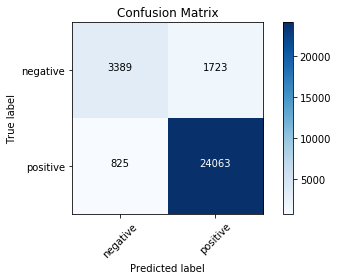


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 24063  |
|           TN (True Negative)           |  3389  |
|          FP (False Positive)           |  1723  |
|          FN (False Negative)           |  825   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.66  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.34  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 91.51% |
+----------------------------------------+--------+


Wall time: 5h 42min 39s


In [14]:
%%time

# Grid search cross Validation on bow
gscv = GridSearchCV(SVC(kernel='rbf'), 
                    scoring="accuracy",
                    param_grid=parameters,                    
                    cv = TimeSeriesSplit(n_splits=2),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
gscv.fit(x_train_matrix,Y_TRAIN)

print("Best Hyperparameter 'C' : ",gscv.best_params_.get('C'))
print("Best Hyperparameter 'Gamma' : ",gscv.best_params_.get('gamma'))
print("Accuracy on BoW : %.2f%%"%(gscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,x_train_matrix,x_test_matrix)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 80.9min finished


Best Hyperparameter 'C' :  32
Best Hyperparameter 'Gamma' :  0.5
Accuracy on BoW : 91.48%
-------------------------- RandomizedSearchCV --------------------------

+--------------------------------------------------------------------------+
|                            RandomizedSearchCV                            |
+--------------------+------------------------+----------+------+----------+
| Hyperparameter (C) | Hyperparameter (gamma) | Scoring  | Mean | Variance |
+--------------------+------------------------+----------+------+----------+
|         32         |           32           | Accuracy | 0.84 |   0.01   |
|         32         |          0.5           | Accuracy | 0.91 |   0.01   |
|         2          |           32           | Accuracy | 0.84 |   0.01   |
|       0.125        |           2            | Accuracy | 0.84 |   0.01   |
|         2          |         0.125          | Accuracy | 0.90 |   0.02   |
|        0.5         |        0.03125         | Accuracy | 0.84 | 

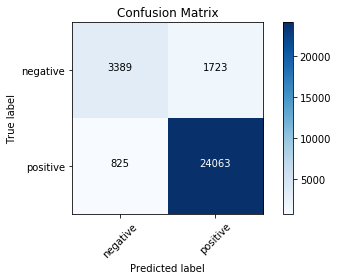


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 24063  |
|           TN (True Negative)           |  3389  |
|          FP (False Positive)           |  1723  |
|          FN (False Negative)           |  825   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.66  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.34  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 91.51% |
+----------------------------------------+--------+


Wall time: 2h 15min 14s


In [15]:
%%time

# Randomized search cross Validation on bow
rscv = RandomizedSearchCV(SVC(kernel='rbf'), 
                    scoring="accuracy",
                    param_distributions=parameters,                    
                    cv = TimeSeriesSplit(n_splits=2),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
rscv.fit(x_train_matrix,Y_TRAIN)

print("Best Hyperparameter 'C' : ",rscv.best_params_.get('C'))
print("Best Hyperparameter 'Gamma' : ",rscv.best_params_.get('gamma'))
print("Accuracy on BoW : %.2f%%"%(rscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(rscv,x_train_matrix,x_test_matrix)

#### (2.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

In [16]:
%%time

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)
x_test_matrix = tfidf_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])

# Data Normalization
x_train_matrix = preprocessing.normalize(x_train_matrix)
x_test_matrix = preprocessing.normalize(x_test_matrix)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (70000, 166323)
The number of unique words in train matrix  166323
Wall time: 12.4 s


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 143.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 736.9min finished


Best Hyperparameter 'C' :  32
Best Hyperparameter 'Gamma' :  0.03125
Accuracy on TF-IDF : 91.90%
-------------------------- GridSearchCV --------------------------

+--------------------------------------------------------------------------+
|                               GridSearchCV                               |
+--------------------+------------------------+----------+------+----------+
| Hyperparameter (C) | Hyperparameter (gamma) | Scoring  | Mean | Variance |
+--------------------+------------------------+----------+------+----------+
|      0.03125       |        0.03125         | Accuracy | 0.84 |   0.02   |
|      0.03125       |         0.125          | Accuracy | 0.84 |   0.02   |
|      0.03125       |          0.5           | Accuracy | 0.84 |   0.02   |
|      0.03125       |           2            | Accuracy | 0.84 |   0.02   |
|      0.03125       |           8            | Accuracy | 0.84 |   0.02   |
|      0.03125       |           32           | Accuracy | 0.84 |

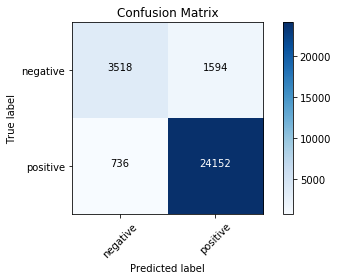


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 24152  |
|           TN (True Negative)           |  3518  |
|          FP (False Positive)           |  1594  |
|          FN (False Negative)           |  736   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.69  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.31  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 92.23% |
+----------------------------------------+--------+


Wall time: 13h 8min 15s


In [17]:
%%time

# Grid search cross Validation on bow
gscv = GridSearchCV(SVC(kernel='rbf'), 
                    scoring="accuracy",
                    param_grid=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
gscv.fit(x_train_matrix,Y_TRAIN)

print("Best Hyperparameter 'C' : ",gscv.best_params_.get('C'))
print("Best Hyperparameter 'Gamma' : ",gscv.best_params_.get('gamma'))
print("Accuracy on TF-IDF : %.2f%%"%(gscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,x_train_matrix,x_test_matrix)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 146.9min finished


Best Hyperparameter 'C' :  32
Best Hyperparameter 'Gamma' :  0.125
Accuracy on TF-IDF : 91.82%
-------------------------- RandomizedSearchCV --------------------------

+--------------------------------------------------------------------------+
|                            RandomizedSearchCV                            |
+--------------------+------------------------+----------+------+----------+
| Hyperparameter (C) | Hyperparameter (gamma) | Scoring  | Mean | Variance |
+--------------------+------------------------+----------+------+----------+
|       0.125        |         0.125          | Accuracy | 0.84 |   0.02   |
|        0.5         |           2            | Accuracy | 0.85 |   0.02   |
|        0.5         |         0.125          | Accuracy | 0.85 |   0.02   |
|        0.5         |           32           | Accuracy | 0.84 |   0.02   |
|       0.125        |          0.5           | Accuracy | 0.84 |   0.02   |
|      0.03125       |           2            | Accuracy | 0.

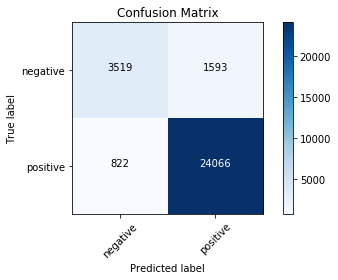


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 24066  |
|           TN (True Negative)           |  3519  |
|          FP (False Positive)           |  1593  |
|          FN (False Negative)           |  822   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.69  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.31  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 91.95% |
+----------------------------------------+--------+


Wall time: 3h 28min 47s


In [18]:
%%time

# Randomized search cross Validation on bow
rscv = RandomizedSearchCV(SVC(kernel='rbf'), 
                    scoring="accuracy",
                    param_distributions=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
rscv.fit(x_train_matrix,Y_TRAIN)

print("Best Hyperparameter 'C' : ",rscv.best_params_.get('C'))
print("Best Hyperparameter 'Gamma' : ",rscv.best_params_.get('gamma'))
print("Accuracy on TF-IDF : %.2f%%"%(rscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(rscv,x_train_matrix,x_test_matrix)

#### (2.3) Average Word2Vec :

In [19]:
%%time

# Create our own Word2Vec model from training data.
        
# Make list of list from training data
list_of_sentences_in_train=[]
for sentence in X_TRAIN:
    list_of_sentences_in_train.append(sentence.split())
            
# Make list of list from testing data - this will be useful when vectorizing testing data.
list_of_sentences_in_test=[]
for sentence in X_TEST:
    list_of_sentences_in_test.append(sentence.split())
            
print("Shape of training data : ",X_TRAIN.shape)
print("Shape of testing data : ",X_TEST.shape)
print("Number of sentences present in training data : ",len(list_of_sentences_in_train))
print("Number of sentences present in testing data : ",len(list_of_sentences_in_test))
        
# Generate model
w2v_model = Word2Vec(list_of_sentences_in_train,min_count=3,size=100, workers=6)
        
# List of word in vocabulary 
w2v_words = list(w2v_model.wv.vocab)
print("Length of vocabulary : ",len(w2v_words))

# Prepare train vectorizer using trained word2vec model
train_list = []
for sentence in tqdm(list_of_sentences_in_train,unit=" sentence",desc='Average Word2Vec - Train data'):
    word_2_vec = np.zeros(100)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    train_list.append(word_2_vec)
        
# Prepare test vectorizer using trained word2vec model
test_list = []
for sentence in tqdm(list_of_sentences_in_test,unit=" sentence",desc='Average Word2Vec - Test data'):
    word_2_vec = np.zeros(100)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    test_list.append(word_2_vec)
            
avg_w2v_train = np.array(train_list)
avg_w2v_test = np.array(test_list)
           

print("\nShape of training vectorizer : ",avg_w2v_train.shape)
print("Shape of testing vectorizer : ",avg_w2v_test.shape)

Shape of training data :  (70000,)
Shape of testing data :  (30000,)
Number of sentences present in training data :  70000
Number of sentences present in testing data :  30000
Length of vocabulary :  13820


Average Word2Vec - Test data: 100%|█████████████████████████████████████| 30000/30000 [00:28<00:00, 1292.74 sentence/s]



Shape of training vectorizer :  (70000, 100)
Shape of testing vectorizer :  (30000, 100)
Wall time: 1min 38s


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 85.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 404.0min finished


Best Hyperparameter 'C' :  8
Best Hyperparameter 'Gamma' :  0.03125
Accuracy on TF-IDF : 90.36%
-------------------------- GridSearchCV --------------------------

+--------------------------------------------------------------------------+
|                               GridSearchCV                               |
+--------------------+------------------------+----------+------+----------+
| Hyperparameter (C) | Hyperparameter (gamma) | Scoring  | Mean | Variance |
+--------------------+------------------------+----------+------+----------+
|      0.03125       |        0.03125         | Accuracy | 0.85 |   0.02   |
|      0.03125       |         0.125          | Accuracy | 0.85 |   0.02   |
|      0.03125       |          0.5           | Accuracy | 0.84 |   0.02   |
|      0.03125       |           2            | Accuracy | 0.84 |   0.02   |
|      0.03125       |           8            | Accuracy | 0.84 |   0.02   |
|      0.03125       |           32           | Accuracy | 0.84 | 

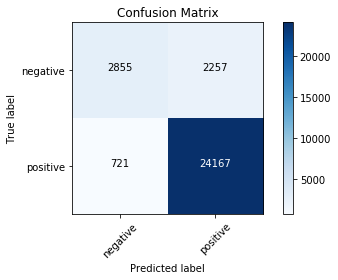


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 24167  |
|           TN (True Negative)           |  2855  |
|          FP (False Positive)           |  2257  |
|          FN (False Negative)           |  721   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.56  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.44  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 90.07% |
+----------------------------------------+--------+


Wall time: 6h 52min 46s


In [20]:
%%time

# Grid search cross Validation on bow
gscv = GridSearchCV(SVC(kernel='rbf'), 
                    scoring="accuracy",
                    param_grid=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
gscv.fit(avg_w2v_train,Y_TRAIN)

print("Best Hyperparameter 'C' : ",gscv.best_params_.get('C'))
print("Best Hyperparameter 'Gamma' : ",gscv.best_params_.get('gamma'))
print("Accuracy on TF-IDF : %.2f%%"%(gscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,avg_w2v_train,avg_w2v_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 100.6min finished


Best Hyperparameter 'C' :  8
Best Hyperparameter 'Gamma' :  0.03125
Accuracy on TF-IDF : 90.36%
-------------------------- RandomizedSearchCV --------------------------

+--------------------------------------------------------------------------+
|                            RandomizedSearchCV                            |
+--------------------+------------------------+----------+------+----------+
| Hyperparameter (C) | Hyperparameter (gamma) | Scoring  | Mean | Variance |
+--------------------+------------------------+----------+------+----------+
|       0.125        |         0.125          | Accuracy | 0.88 |   0.01   |
|       0.125        |        0.03125         | Accuracy | 0.88 |   0.02   |
|        0.5         |           8            | Accuracy | 0.84 |   0.02   |
|         8          |         0.125          | Accuracy | 0.90 |   0.01   |
|      0.03125       |          0.5           | Accuracy | 0.84 |   0.02   |
|         2          |           8            | Accuracy | 0

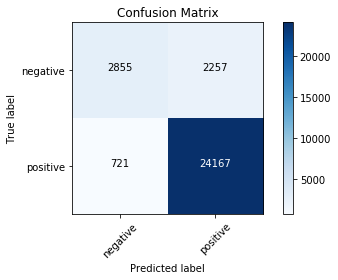


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 24167  |
|           TN (True Negative)           |  2855  |
|          FP (False Positive)           |  2257  |
|          FN (False Negative)           |  721   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.56  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.44  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 90.07% |
+----------------------------------------+--------+


Wall time: 1h 50min 2s


In [21]:
%%time

# Randomized search cross Validation on bow
rscv = RandomizedSearchCV(SVC(kernel='rbf'), 
                    scoring="accuracy",
                    param_distributions=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
rscv.fit(avg_w2v_train,Y_TRAIN)

print("Best Hyperparameter 'C' : ",rscv.best_params_.get('C'))
print("Best Hyperparameter 'Gamma' : ",rscv.best_params_.get('gamma'))
print("Accuracy on TF-IDF : %.2f%%"%(rscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(rscv,avg_w2v_train,avg_w2v_test)

#### (2.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec(TF-IDF Word2Vec) :

In [22]:
%%time

# Make list of list from training data.      
sentences_in_train=[]
for sentence in X_TRAIN:
    sentences_in_train.append(sentence.split())

# Make list of list from testing data - this will be useful when vectorizing testing data.
sentences_in_test=[]
for sentence in X_TEST:
    sentences_in_test.append(sentence.split())
            
# Generate model
w2v_model = Word2Vec(sentences_in_train,min_count=3,size=100, workers=6)

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()

# Dictionary with word as a key, and the idf as a value
dict_word_idf = dict(zip(feature_names, list(tfidf_vectorizer.idf_)))

# Prepare train vectorizer using trained word2vec model        
train_list = []
row = 0
for sentence in tqdm(sentences_in_train,unit=" sentence",desc='TF-IDF Weighted Word2Vec - Train data'):
    word_2_vec = np.zeros(100)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    train_list.append(word_2_vec)
    row += 1
        
# Prepare test vectorizer using trained word2vec model
test_list = []
row = 0
for sentence in tqdm(sentences_in_test, unit=" sentence",desc='TF-IDF Weighted Word2Vec - Test data'):
    word_2_vec = np.zeros(100)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    test_list.append(word_2_vec)
    row += 1
        
tfidf_w2v_train = np.array(train_list)
tfidf_w2v_test = np.array(test_list)


print("\nShape of training vectorizer : ",tfidf_w2v_train.shape)
print("Shape of testing vectorizer : ",tfidf_w2v_test.shape)

TF-IDF Weighted Word2Vec - Test data: 100%|█████████████████████████████| 30000/30000 [00:08<00:00, 3453.16 sentence/s]



Shape of training vectorizer :  (70000, 100)
Shape of testing vectorizer :  (30000, 100)
Wall time: 46.6 s


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 88.9min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 418.5min finished


Best Hyperparameter 'C' :  8
Best Hyperparameter 'Gamma' :  0.03125
Accuracy on TF-IDF Weighted Word2Vec : 89.40%
-------------------------- GridSearchCV --------------------------

+--------------------------------------------------------------------------+
|                               GridSearchCV                               |
+--------------------+------------------------+----------+------+----------+
| Hyperparameter (C) | Hyperparameter (gamma) | Scoring  | Mean | Variance |
+--------------------+------------------------+----------+------+----------+
|      0.03125       |        0.03125         | Accuracy | 0.85 |   0.02   |
|      0.03125       |         0.125          | Accuracy | 0.85 |   0.02   |
|      0.03125       |          0.5           | Accuracy | 0.84 |   0.02   |
|      0.03125       |           2            | Accuracy | 0.84 |   0.02   |
|      0.03125       |           8            | Accuracy | 0.84 |   0.02   |
|      0.03125       |           32           | 

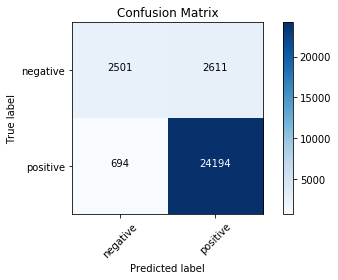


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 24194  |
|           TN (True Negative)           |  2501  |
|          FP (False Positive)           |  2611  |
|          FN (False Negative)           |  694   |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.49  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.51  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 88.98% |
+----------------------------------------+--------+


Wall time: 7h 9min 14s


In [23]:
%%time

# Grid search cross Validation on bow
gscv = GridSearchCV(SVC(kernel='rbf'), 
                    scoring="accuracy",
                    param_grid=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
gscv.fit(tfidf_w2v_train,Y_TRAIN)

print("Best Hyperparameter 'C' : ",gscv.best_params_.get('C'))
print("Best Hyperparameter 'Gamma' : ",gscv.best_params_.get('gamma'))
print("Accuracy on TF-IDF Weighted Word2Vec : %.2f%%"%(gscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(gscv,tfidf_w2v_train,tfidf_w2v_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 147.3min finished


Best Hyperparameter 'C' :  8
Best Hyperparameter 'Gamma' :  0.125
Accuracy on TF-IDF : 88.66%
-------------------------- RandomizedSearchCV --------------------------

+--------------------------------------------------------------------------+
|                            RandomizedSearchCV                            |
+--------------------+------------------------+----------+------+----------+
| Hyperparameter (C) | Hyperparameter (gamma) | Scoring  | Mean | Variance |
+--------------------+------------------------+----------+------+----------+
|        0.5         |           2            | Accuracy | 0.84 |   0.02   |
|         8          |           32           | Accuracy | 0.84 |   0.02   |
|         8          |           2            | Accuracy | 0.84 |   0.02   |
|      0.03125       |         0.125          | Accuracy | 0.85 |   0.02   |
|         32         |           8            | Accuracy | 0.84 |   0.02   |
|       0.125        |        0.03125         | Accuracy | 0.8

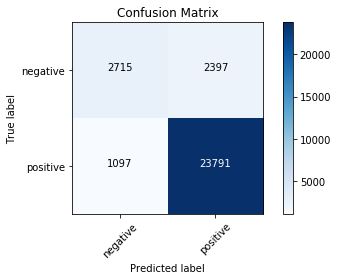


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 23791  |
|           TN (True Negative)           |  2715  |
|          FP (False Positive)           |  2397  |
|          FN (False Negative)           |  1097  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.96  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.53  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.47  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.04  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 88.35% |
+----------------------------------------+--------+


Wall time: 3h 41s


In [24]:
%%time

# Randomized search cross Validation on bow
rscv = RandomizedSearchCV(SVC(kernel='rbf'), 
                    scoring="accuracy",
                    param_distributions=parameters,                    
                    cv = TimeSeriesSplit(n_splits=3),
                    verbose=1, 
                    n_jobs=-1)
# Fit the model
rscv.fit(tfidf_w2v_train,Y_TRAIN)

print("Best Hyperparameter 'C' : ",rscv.best_params_.get('C'))
print("Best Hyperparameter 'Gamma' : ",rscv.best_params_.get('gamma'))
print("Accuracy on TF-IDF : %.2f%%"%(rscv.best_score_*100))

# Perform performance meausre,plot and draw reports.
performance_measure(rscv,tfidf_w2v_train,tfidf_w2v_test)

---
### Conclusion :
---

In [25]:
conclude_RBF_SVC()

+----------------------------------------------------------------------------------------------------------------------------+
|                                                *** Conclusion - RBF-SVC ***                                                |
+--------------------+------------------------+--------------------+-----------------------+--------------------+------------+
|         CV         |         Model          | Hyperparameter 'C' | Hyperparameter 'gamma |    Train Error     | Test Error |
+--------------------+------------------------+--------------------+-----------------------+--------------------+------------+
|    GridSearchCV    |      BOW:RBF-SVC       |         32         |          0.5          |        0.0%        |    8.0%    |
| RandomizedSearchCV |      BOW:RBF-SVC       |         32         |          0.5          |        0.0%        |    8.0%    |
|    GridSearchCV    |     TFIDF:RBF-SVC      |         32         |        0.03125        |        1.0%       

### (3) Linear SVM :


In [26]:
# Load dataset ~ 364K
reviews_df = joblib.load('reviews_364k.joblib')

# Convert timestamp to datetime.
reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

# Sort the data on the basis of time.
reviews_df = reviews_df.sort_values(by=['Time'])

print("Dataset Shape : \n",reviews_df.shape)
print("\nColumn Names: \n",reviews_df.columns)
print("\nTarget Class label : ")
print(reviews_df['Score'].value_counts())
print()   
    

# Split data into train and test
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(reviews_df['CleanedText'].values,
                                                    reviews_df['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False,
                                                    random_state=0)


Dataset Shape : 
 (351237, 11)

Column Names: 
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

Target Class label : 
positive    297807
negative     53430
Name: Score, dtype: int64



In [27]:
# hyperparameter gamma
list_alpha = []

# Training Error
train_error = []

# Test Error
test_error = []

#parameters for SGDClassifer's alpha.
param_grid = {'alpha':[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]}

In [28]:
# Instantiate SGDClassifier
sgdClassifier = SGDClassifier(loss="hinge",
                             penalty="l2",                            
                             max_iter = 2000,
                             tol = 0.0001,
                             shuffle = True,                             
                             n_jobs = -1,
                             learning_rate = "optimal",
                             class_weight ="balanced")

#### (3.1) Bag of Words (BoW) :

In [29]:
%%time

# Instantiate CountVectorizer
bow_count_vectorizer = CountVectorizer()

# Tokenize and build vocab
bow_count_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = bow_count_vectorizer.transform(X_TRAIN)
x_test_matrix = bow_count_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])

# Data Normalization
x_train_matrix = preprocessing.normalize(x_train_matrix)
x_test_matrix = preprocessing.normalize(x_test_matrix)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (245865, 74398)
The number of unique words in train matrix  74398
Wall time: 15.2 s


In [30]:
%%time

# Instantiate GridSearchCV and perform 5-fold cross validation
gscv = GridSearchCV(sgdClassifier,
                    param_grid = param_grid,
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 6)

# Fit the model
gscv.fit(x_train_matrix,Y_TRAIN)

optimal_alpha = gscv.best_params_.get('alpha')
list_alpha.append(optimal_alpha)

print() 
print("Best HyperParameter: ",optimal_alpha)
print("Best Accuracy on Train Data: %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   22.0s finished



Best HyperParameter:  1e-05
Best Accuracy on Train Data: 87.53%
Wall time: 24.6 s


In [31]:
# Get estimator back with best parameters
classifier = gscv.best_estimator_

classifier

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=2000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)


+------------------------------------------------------------------+
|             Classification Report with alpha = 1e-05             |
+----------------------+-----------+--------+----------+-----------+
| Class Lable/Averages | Precision | Recall | F1-Score |  Support  |
+----------------------+-----------+--------+----------+-----------+
|       negative       |    0.59   |  0.88  |   0.71   |  17838.00 |
|       positive       |    0.97   |  0.88  |   0.92   |  87534.00 |
|      micro avg       |    0.88   |  0.88  |   0.88   | 105372.00 |
|      macro avg       |    0.78   |  0.88  |   0.82   | 105372.00 |
|     weighted avg     |    0.91   |  0.88  |   0.89   | 105372.00 |
+----------------------+-----------+--------+----------+-----------+


Accuracy on Test Data: 87.82%


--------------- Confusion Matrix of Test Data ---------------


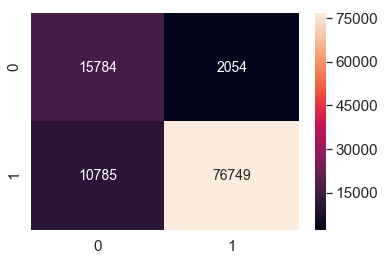

In [32]:
predicted_y_train = classifier.predict(x_train_matrix)
predicted_y_test = classifier.predict(x_test_matrix)

print()          
ptable = PrettyTable()
ptable.title = "Classification Report with alpha = {0}".format(optimal_alpha)
ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
report_dict = classification_report(Y_TEST, predicted_y_test,output_dict = True)
for key , value in report_dict.items():        
    inner_dict = value        
    ptable.add_row([key,
                    "{0:.2f}".format(inner_dict['precision']),
                    "{0:.2f}".format(inner_dict['recall']),
                    "{0:.2f}".format(inner_dict['f1-score']),
                    "{0:.2f}".format(inner_dict['support'])])
            
print(ptable)
print()
print()

train_accuracy = accuracy_score(Y_TRAIN,predicted_y_train)
train_error.append(1-train_accuracy) 

test_accuracy = accuracy_score(Y_TEST,predicted_y_test)
test_error.append(1-test_accuracy) 

print("Accuracy on Test Data: %0.2f%%"%(test_accuracy*100))
print()
print()
print("--------------- Confusion Matrix of Test Data ---------------")
sns.set(font_scale=1.4)
sns.heatmap(pd.DataFrame(confusion_matrix(Y_TEST, predicted_y_test), range(2),range(2)), 
            annot=True,
            annot_kws={"size": 14}, 
            fmt='g')

#### (3.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

In [33]:
%%time

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)
x_test_matrix = tfidf_vectorizer.transform(X_TEST)

print("\nThe type of count vectorizer ",type(x_train_matrix))
print("The shape of train matrix ",x_train_matrix.get_shape())
print("The number of unique words in train matrix ", x_train_matrix.get_shape()[1])

# Data Normalization
x_train_matrix = preprocessing.normalize(x_train_matrix)
x_test_matrix = preprocessing.normalize(x_test_matrix)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train matrix  (245865, 487621)
The number of unique words in train matrix  487621
Wall time: 45.2 s


In [34]:
%%time

# Instantiate GridSearchCV and perform 5-fold cross validation
gscv = GridSearchCV(sgdClassifier,
                    param_grid = param_grid,
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 6)

# Fit the model
gscv.fit(x_train_matrix,Y_TRAIN)

optimal_alpha = gscv.best_params_.get('alpha')
list_alpha.append(optimal_alpha)

print() 
print("Best HyperParameter: ",optimal_alpha)
print("Best Accuracy on Train Data: %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   46.1s finished



Best HyperParameter:  1e-05
Best Accuracy on Train Data: 92.32%
Wall time: 50.9 s


In [35]:
# Get estimator back with best parameters
classifier = gscv.best_estimator_

classifier

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=2000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)


+------------------------------------------------------------------+
|             Classification Report with alpha = 1e-05             |
+----------------------+-----------+--------+----------+-----------+
| Class Lable/Averages | Precision | Recall | F1-Score |  Support  |
+----------------------+-----------+--------+----------+-----------+
|       negative       |    0.69   |  0.88  |   0.77   |  17838.00 |
|       positive       |    0.97   |  0.92  |   0.95   |  87534.00 |
|      micro avg       |    0.91   |  0.91  |   0.91   | 105372.00 |
|      macro avg       |    0.83   |  0.90  |   0.86   | 105372.00 |
|     weighted avg     |    0.93   |  0.91  |   0.92   | 105372.00 |
+----------------------+-----------+--------+----------+-----------+


Accuracy on Test Data: 91.36%


--------------- Confusion Matrix of Test Data ---------------


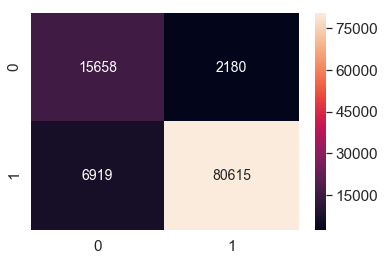

In [36]:
predicted_y_train = classifier.predict(x_train_matrix)
predicted_y_test = classifier.predict(x_test_matrix)

print()          
ptable = PrettyTable()
ptable.title = "Classification Report with alpha = {0}".format(optimal_alpha)
ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
report_dict = classification_report(Y_TEST, predicted_y_test,output_dict = True)
for key , value in report_dict.items():        
    inner_dict = value        
    ptable.add_row([key,
                    "{0:.2f}".format(inner_dict['precision']),
                    "{0:.2f}".format(inner_dict['recall']),
                    "{0:.2f}".format(inner_dict['f1-score']),
                    "{0:.2f}".format(inner_dict['support'])])
            
print(ptable)
print()
print()

train_accuracy =  accuracy_score(Y_TRAIN,predicted_y_train)
train_error.append(1-train_accuracy) 

test_accuracy =  accuracy_score(Y_TEST,predicted_y_test)
test_error.append(1-test_accuracy) 

print("Accuracy on Test Data: %0.2f%%"%(test_accuracy*100))
print()
print()
print("--------------- Confusion Matrix of Test Data ---------------")
sns.set(font_scale=1.4)
sns.heatmap(pd.DataFrame(confusion_matrix(Y_TEST, predicted_y_test), range(2),range(2)), 
            annot=True,
            annot_kws={"size": 14}, 
            fmt='g')

#### (3.3) Average Word2Vec :

In [37]:
%%time

# Create our own Word2Vec model from training data.
        
# Make list of list from training data
list_of_sentences_in_train=[]
for sentence in X_TRAIN:
    list_of_sentences_in_train.append(sentence.split())
            
# Make list of list from testing data - this will be useful when vectorizing testing data.
list_of_sentences_in_test=[]
for sentence in X_TEST:
    list_of_sentences_in_test.append(sentence.split())
            
print("Shape of training data : ",X_TRAIN.shape)
print("Shape of testing data : ",X_TEST.shape)
print("Number of sentences present in training data : ",len(list_of_sentences_in_train))
print("Number of sentences present in testing data : ",len(list_of_sentences_in_test))
        
# Generate model
w2v_model = Word2Vec(list_of_sentences_in_train,min_count=3,size=200, workers=6)
        
# List of word in vocabulary 
w2v_words = list(w2v_model.wv.vocab)
print("Length of vocabulary : ",len(w2v_words))

# Prepare train vectorizer using trained word2vec model
train_list = []
for sentence in tqdm(list_of_sentences_in_train,unit=" sentence",desc='Average Word2Vec - Train data'):
    word_2_vec = np.zeros(200)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    train_list.append(word_2_vec)
        
# Prepare test vectorizer using trained word2vec model
test_list = []
for sentence in tqdm(list_of_sentences_in_test,unit=" sentence",desc='Average Word2Vec - Test data'):
    word_2_vec = np.zeros(200)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    test_list.append(word_2_vec)
            
avg_w2v_train = np.array(train_list)
avg_w2v_test = np.array(test_list)
           

print("\nShape of training vectorizer : ",avg_w2v_train.shape)
print("Shape of testing vectorizer : ",avg_w2v_test.shape)

Shape of training data :  (245865,)
Shape of testing data :  (105372,)
Number of sentences present in training data :  245865
Number of sentences present in testing data :  105372
Length of vocabulary :  24460


Average Word2Vec - Test data: 100%|████████████████████████████████████| 105372/105372 [02:15<00:00, 778.30 sentence/s]



Shape of training vectorizer :  (245865, 200)
Shape of testing vectorizer :  (105372, 200)
Wall time: 7min 32s


In [38]:
%%time

# Instantiate GridSearchCV and perform 5-fold cross validation
gscv = GridSearchCV(sgdClassifier,
                    param_grid = param_grid,
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 6)

# Fit the model
gscv.fit(avg_w2v_train,Y_TRAIN)

optimal_alpha = gscv.best_params_.get('alpha')
list_alpha.append(optimal_alpha)

print() 
print("Best HyperParameter: ",optimal_alpha)
print("Best Accuracy on Train Data: %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.1min finished



Best HyperParameter:  0.0005
Best Accuracy on Train Data: 85.33%
Wall time: 1min 6s


In [39]:
# Get estimator back with best parameters
classifier = gscv.best_estimator_

classifier

SGDClassifier(alpha=0.0005, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=2000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)


+------------------------------------------------------------------+
|            Classification Report with alpha = 0.0005             |
+----------------------+-----------+--------+----------+-----------+
| Class Lable/Averages | Precision | Recall | F1-Score |  Support  |
+----------------------+-----------+--------+----------+-----------+
|       negative       |    0.52   |  0.88  |   0.66   |  17838.00 |
|       positive       |    0.97   |  0.84  |   0.90   |  87534.00 |
|      micro avg       |    0.84   |  0.84  |   0.84   | 105372.00 |
|      macro avg       |    0.75   |  0.86  |   0.78   | 105372.00 |
|     weighted avg     |    0.90   |  0.84  |   0.86   | 105372.00 |
+----------------------+-----------+--------+----------+-----------+


Accuracy on Test Data: 84.40%


--------------- Confusion Matrix of Test Data ---------------


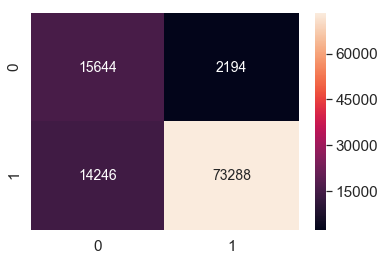

In [40]:
predicted_y_train = classifier.predict(avg_w2v_train)
predicted_y_test = classifier.predict(avg_w2v_test)

print()          
ptable = PrettyTable()
ptable.title = "Classification Report with alpha = {0}".format(optimal_alpha)
ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
report_dict = classification_report(Y_TEST, predicted_y_test,output_dict = True)
for key , value in report_dict.items():        
    inner_dict = value        
    ptable.add_row([key,
                    "{0:.2f}".format(inner_dict['precision']),
                    "{0:.2f}".format(inner_dict['recall']),
                    "{0:.2f}".format(inner_dict['f1-score']),
                    "{0:.2f}".format(inner_dict['support'])])
            
print(ptable)
print()
print()

train_accuracy =  accuracy_score(Y_TRAIN,predicted_y_train)
train_error.append(1-train_accuracy) 

test_accuracy =  accuracy_score(Y_TEST,predicted_y_test)
test_error.append(1-test_accuracy) 

print("Accuracy on Test Data: %0.2f%%"%(test_accuracy*100))
print()
print()
print("--------------- Confusion Matrix of Test Data ---------------")
sns.set(font_scale=1.4)
sns.heatmap(pd.DataFrame(confusion_matrix(Y_TEST, predicted_y_test), range(2),range(2)), 
            annot=True,
            annot_kws={"size": 14}, 
            fmt='g')

#### (3.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec(TF-IDF Word2Vec) :

In [41]:
%%time

# Make list of list from training data.      
sentences_in_train=[]
for sentence in X_TRAIN:
    sentences_in_train.append(sentence.split())

# Make list of list from testing data - this will be useful when vectorizing testing data.
sentences_in_test=[]
for sentence in X_TEST:
    sentences_in_test.append(sentence.split())
            
# Generate model
w2v_model = Word2Vec(sentences_in_train,min_count=3,size=200, workers=6)

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(X_TRAIN)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(X_TRAIN)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()

# Dictionary with word as a key, and the idf as a value
dict_word_idf = dict(zip(feature_names, list(tfidf_vectorizer.idf_)))

# Prepare train vectorizer using trained word2vec model        
train_list = []
row = 0
for sentence in tqdm(sentences_in_train,unit=" sentence",desc='TF-IDF Weighted Word2Vec - Train data'):
    word_2_vec = np.zeros(200)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    train_list.append(word_2_vec)
    row += 1
        
# Prepare test vectorizer using trained word2vec model
test_list = []
row = 0
for sentence in tqdm(sentences_in_test, unit=" sentence",desc='TF-IDF Weighted Word2Vec - Test data'):
    word_2_vec = np.zeros(200)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    test_list.append(word_2_vec)
    row += 1
        
tfidf_w2v_train = np.array(train_list)
tfidf_w2v_test = np.array(test_list)


print("\nShape of training vectorizer : ",tfidf_w2v_train.shape)
print("Shape of testing vectorizer : ",tfidf_w2v_test.shape)

TF-IDF Weighted Word2Vec - Test data: 100%|███████████████████████████| 105372/105372 [00:31<00:00, 3297.66 sentence/s]



Shape of training vectorizer :  (245865, 200)
Shape of testing vectorizer :  (105372, 200)
Wall time: 2min 46s


In [42]:
%%time

# Instantiate GridSearchCV and perform 5-fold cross validation
gscv = GridSearchCV(sgdClassifier,
                    param_grid = param_grid,
                    cv = TimeSeriesSplit(n_splits=5),
                    n_jobs = -1,
                    verbose = 6)

# Fit the model
gscv.fit(tfidf_w2v_train,Y_TRAIN)

optimal_alpha = gscv.best_params_.get('alpha')
list_alpha.append(optimal_alpha)


print() 
print("Best HyperParameter: ",optimal_alpha)
print("Best Accuracy on Train Data: %.2f%%"%(gscv.best_score_*100))


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished



Best HyperParameter:  500
Best Accuracy on Train Data: 84.78%
Wall time: 1min 11s


In [43]:
# Get estimator back with best parameters
classifier = gscv.best_estimator_

classifier

SGDClassifier(alpha=500, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=2000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)


+------------------------------------------------------------------+
|              Classification Report with alpha = 500              |
+----------------------+-----------+--------+----------+-----------+
| Class Lable/Averages | Precision | Recall | F1-Score |  Support  |
+----------------------+-----------+--------+----------+-----------+
|       negative       |    0.00   |  0.00  |   0.00   |  17838.00 |
|       positive       |    0.83   |  1.00  |   0.91   |  87534.00 |
|      micro avg       |    0.83   |  0.83  |   0.83   | 105372.00 |
|      macro avg       |    0.42   |  0.50  |   0.45   | 105372.00 |
|     weighted avg     |    0.69   |  0.83  |   0.75   | 105372.00 |
+----------------------+-----------+--------+----------+-----------+


Accuracy on Test Data: 83.07%


--------------- Confusion Matrix of Test Data ---------------


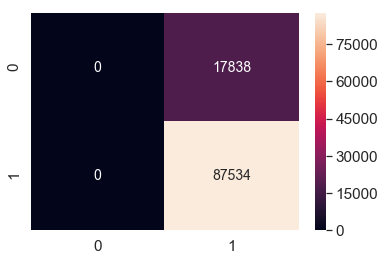

In [44]:
predicted_y_train = classifier.predict(tfidf_w2v_train)
predicted_y_test = classifier.predict(tfidf_w2v_test)

print()          
ptable = PrettyTable()
ptable.title = "Classification Report with alpha = {0}".format(optimal_alpha)
ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
report_dict = classification_report(Y_TEST, predicted_y_test,output_dict = True)
for key , value in report_dict.items():        
    inner_dict = value        
    ptable.add_row([key,
                    "{0:.2f}".format(inner_dict['precision']),
                    "{0:.2f}".format(inner_dict['recall']),
                    "{0:.2f}".format(inner_dict['f1-score']),
                    "{0:.2f}".format(inner_dict['support'])])
            
print(ptable)
print()
print()

train_accuracy =  accuracy_score(Y_TRAIN,predicted_y_train)
train_error.append(1-train_accuracy) 

test_accuracy =  accuracy_score(Y_TEST,predicted_y_test)
test_error.append(1-test_accuracy) 

print("Accuracy on Test Data: %0.2f%%"%(test_accuracy*100))
print()
print()
print("--------------- Confusion Matrix of Test Data ---------------")
sns.set(font_scale=1.4)
sns.heatmap(pd.DataFrame(confusion_matrix(Y_TEST, predicted_y_test), range(2),range(2)), 
            annot=True,
            annot_kws={"size": 14}, 
            fmt='g')

---
### Conclusion :
---

In [45]:
conclude_LinearSVM()

+--------------------------------------------------------------------------------------------------------+
|                                    *** Conclusion - Linear-SVM ***                                     |
+--------------+------------------------------+-----------------------+---------------------+------------+
|      CV      |            Model             | Hyperparameter 'alpha |     Train Error     | Test Error |
+--------------+------------------------------+-----------------------+---------------------+------------+
| GridSearchCV |      BOW:SGDClassifier       |         1e-05         |        11.0%        |   12.0%    |
| GridSearchCV |     TFIDF:SGDClassifier      |         1e-05         |         5.0%        |    9.0%    |
| GridSearchCV |  AVG-WORD2VEC:SGDClassifier  |         0.0005        |        15.0%        |   16.0%    |
| GridSearchCV | TFIDF-WORD2VEC:SGDClassifier |          500          | 14.000000000000002% |   17.0%    |
+--------------+---------------------

---
### Observations :
---

> 1. Here, RBF-SVC and Linear SVM is applied on amazon fine food review dataset with time series splitting(~100K and ~364K respectively).
> 2. Given dataset is imbalanced in nature (postive reviews:negative reviews = 5.57/1).
> 3. Grid search and Randomized search cross validation with 2/3-fold technique is applied to calculate optimal hyperparameter 'C' and 'gamma'.
> 4. RBF-SVC takes ample amount of time to trin the model, where as Linear SVM takes less time to train.
> 5. Custom implementation of string kernel with more number of points can be used to increase the performance of the model.
> 6. for more information you can always refer to conclusion table above.